In [1]:
import os
import shutil

import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, RMSprop
from keras.metrics import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob
from pathlib import Path
import random
%matplotlib inline



train_path = 'chest_xray/train/'
valid_path = 'chest_xray/val/'
test_path =  'chest_xray/test/'



train_normal_path = (train_path + 'NORMAL')
train_pneumonia_path = (train_path + 'PNEUMONIA')

valid_normal_path = (valid_path + 'NORMAL')
valid_pneumonia_path = (valid_path + 'PNEUMONIA')

test_normal_path = (test_path + 'NORMAL')
test_pneumonia_path = (test_path + 'PNEUMONIA')


# Place more validation images into the validation folder

for f in os.listdir(valid_normal_path):
    shutil.move(valid_normal_path + '/' + f, train_normal_path + '/' + f)


for f in os.listdir(valid_pneumonia_path):
    shutil.move(valid_pneumonia_path + '/' + f, train_pneumonia_path + '/' + f)

    
new_valid_normal = random.sample(os.listdir(train_normal_path), 100)
new_valid_pneumonia = random.sample(os.listdir(train_pneumonia_path), 100)

for f in new_valid_normal:
    shutil.move(train_normal_path + '/' + f, valid_normal_path + '/' + f)

for f in new_valid_pneumonia:
    shutil.move(train_pneumonia_path + '/' + f, valid_pneumonia_path + '/' + f)

Using TensorFlow backend.


# Data Exploration

In [2]:
# Get ratios of training data


train_numfiles_normal = len([f for f in os.listdir(train_normal_path) if f[0] != '.'])

print ('number of training files for normal cases in x-ray imagery' + ' ' + str(train_numfiles_normal))


train_numfiles_pneumonia = len([f for f in os.listdir(train_pneumonia_path) if f[0] != '.'])

print ('number of training files for pneumonia cases in x-ray imagery' + ' ' + str(train_numfiles_pneumonia))

number of training files for normal cases in x-ray imagery 1249
number of training files for pneumonia cases in x-ray imagery 3783


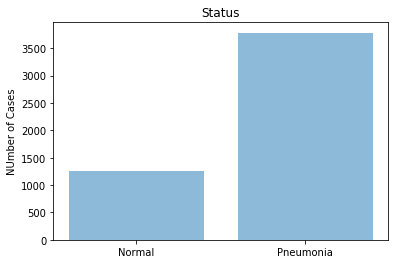

In [3]:
objects = ('Normal', 'Pneumonia')
y_pos = np.arange(len(objects))
performance = [train_numfiles_normal, train_numfiles_pneumonia]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('NUmber of Cases')
plt.title('Status')
 
plt.show()

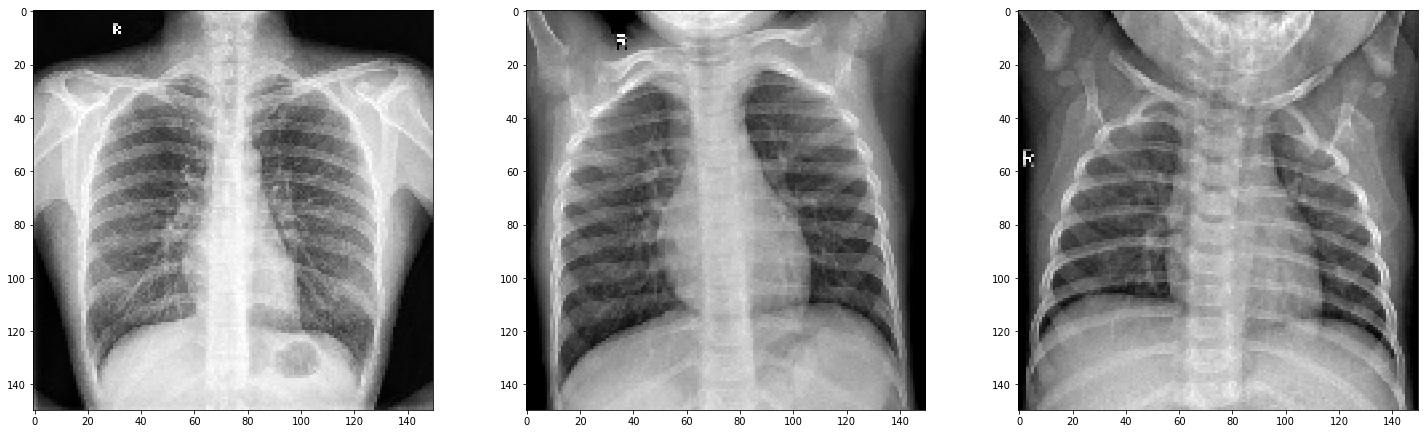

In [4]:
selection_normal_images = glob('chest_xray/train/NORMAL/**')

plt.rcParams['figure.figsize'] = (25.0, 25.0)

i = 0

for img in selection_normal_images[:3]:
    img = cv2.imread(img)
    img = cv2.resize(img, (150, 150)) 
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    i += 1

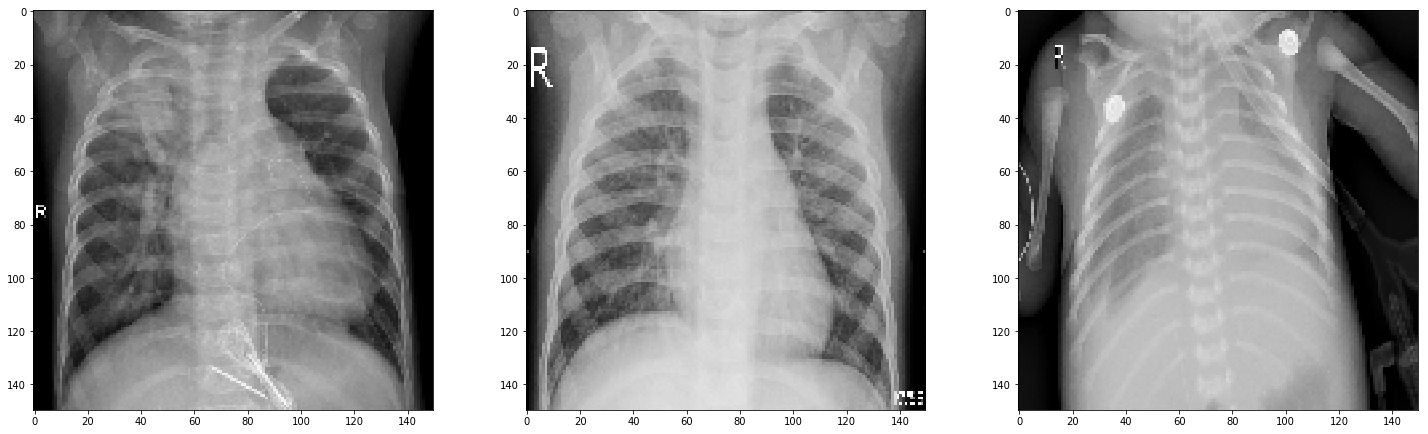

In [5]:
selection_pneumonia_images = glob('chest_xray/train/PNEUMONIA/**')

plt.rcParams['figure.figsize'] = (25.0, 25.0)

i = 0

for img in selection_pneumonia_images[:3]:
    img = cv2.imread(img)
    img = cv2.resize(img, (150, 150)) 
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    i += 1

In [6]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [7]:
# Set keras data generators

train_batches = train_datagen.flow_from_directory(train_path,
                                                  target_size=(224,224),
                                                  classes=['NORMAL', 'PNEUMONIA'],
                                                  batch_size = 30)
valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input_vgg).flow_from_directory(valid_path,
                                                                                                    target_size=(224,224),
                                                                                                    classes=['NORMAL', 'PNEUMONIA'],
                                                                                                    batch_size = 20)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                        target_size=(224,224),
                                                        classes=['NORMAL', 'PNEUMONIA'],
                                                        batch_size = 1)


Found 5032 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Create Compile and Train VGG16 model

In [8]:
vgg16_model = keras.applications.vgg16.VGG16()

In [9]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
# Convert model type

modelvgg16 = Sequential()
for layer in vgg16_model.layers:
    modelvgg16.add(layer)

In [11]:
# Remove the last dense layer dealing with all 1000 classes of imagenet

modelvgg16.layers.pop()

In [12]:
modelvgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
# Freeze layers

for layer in modelvgg16.layers[:15]:
    layer.trainable = False

In [14]:
# Create a binary classification layer

modelvgg16.add(Dense(2, activation='sigmoid'))

In [15]:
modelvgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
modelvgg16.compile(Adam(lr=.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
checkpointer = ModelCheckpoint(filepath='weights_vgg16.hdf5', 
                               verbose=1, save_best_only=True)

modelvgg16.fit_generator(train_batches,
                         steps_per_epoch=160,
                         validation_data=valid_batches,
                         callbacks=[checkpointer],
                         validation_steps=10,
                         epochs=30,
                         verbose=1,
                         class_weight={0:1., 1:0.35})

Epoch 1/30
160/160 [==============================] - 147s - loss: 0.3435 - acc: 0.8906 - val_loss: 0.6714 - val_acc: 0.9175
Epoch 2/30
160/160 [==============================] - 143s - loss: 0.3438 - acc: 0.9250 - val_loss: 0.6695 - val_acc: 0.9450
Epoch 3/30
160/160 [==============================] - 123s - loss: 0.3428 - acc: 0.9379 - val_loss: 0.6699 - val_acc: 0.9250
Epoch 4/30
160/160 [==============================] - 141s - loss: 0.3400 - acc: 0.9447 - val_loss: 0.6678 - val_acc: 0.9550
Epoch 5/30
160/160 [==============================] - 123s - loss: 0.3428 - acc: 0.9499 - val_loss: 0.6687 - val_acc: 0.9275
Epoch 6/30
160/160 [==============================] - 141s - loss: 0.3414 - acc: 0.9478 - val_loss: 0.6660 - val_acc: 0.9600
Epoch 7/30
160/160 [==============================] - 123s - loss: 0.3399 - acc: 0.9652 - val_loss: 0.6661 - val_acc: 0.9450
Epoch 8/30
160/160 [==============================] - 141s - loss: 0.3391 - acc: 0.9600 - val_loss: 0.6644 - val_acc: 0.9600


In [18]:
modelvgg16.load_weights('weights_vgg16.hdf5')

In [19]:
#modelvgg16.save('vgg16_xray_model.h5')

# Create Compile and Train VGG19

In [20]:
vgg19_model = keras.applications.vgg19.VGG19()

In [21]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:
# Convert model type

modelvgg19 = Sequential()
for layer in vgg19_model.layers:
    modelvgg19.add(layer)

In [23]:
modelvgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
# Remove the last dense layer dealing with all 1000 classes of imagenet

modelvgg19.layers.pop()

In [25]:
modelvgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
# Freeze layers

for layer in modelvgg19.layers[:15]:
    layer.trainable = False

In [27]:
modelvgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
# Create a binary classification layer

modelvgg19.add(Dense(2, activation='sigmoid'))

In [29]:
modelvgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [30]:
modelvgg19.compile(Adam(lr=.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
checkpointer = ModelCheckpoint(filepath='weights_vgg19.hdf5', 
                               verbose=1, save_best_only=True)

modelvgg19.fit_generator(train_batches,
                         steps_per_epoch=160,
                         validation_data=valid_batches,
                         callbacks=[checkpointer],
                         validation_steps=10,
                         epochs=30,
                         verbose=1,
                         class_weight={0:1., 1:0.33})

Epoch 1/30
160/160 [==============================] - 178s - loss: 0.3337 - acc: 0.8642 - val_loss: 0.6673 - val_acc: 0.9475
Epoch 2/30
160/160 [==============================] - 176s - loss: 0.3295 - acc: 0.9368 - val_loss: 0.6654 - val_acc: 0.9650
Epoch 3/30
160/160 [==============================] - 158s - loss: 0.3331 - acc: 0.9359 - val_loss: 0.6703 - val_acc: 0.8800
Epoch 4/30
160/160 [==============================] - 158s - loss: 0.3299 - acc: 0.9452 - val_loss: 0.6667 - val_acc: 0.9300
Epoch 5/30
160/160 [==============================] - 177s - loss: 0.3270 - acc: 0.9473 - val_loss: 0.6645 - val_acc: 0.9500
Epoch 6/30
160/160 [==============================] - 177s - loss: 0.3338 - acc: 0.9307 - val_loss: 0.6625 - val_acc: 0.9625
Epoch 7/30
160/160 [==============================] - 158s - loss: 0.3254 - acc: 0.9333 - val_loss: 0.6714 - val_acc: 0.8250
Epoch 8/30
160/160 [==============================] - 177s - loss: 0.3302 - acc: 0.9426 - val_loss: 0.6610 - val_acc: 0.9650


In [32]:
modelvgg19.load_weights('weights_vgg19.hdf5')

In [33]:
#modelvgg19.save('vgg19_xray_model.h5')

# Loading test data

In [34]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load data from directory
# Return array of images in 4D
# Return array image labels
# Return array of image paths

# Test data done separately to have determined order and track individual results

def load_data(path):
    
    data = []
    labels = []
    file_paths = []
    
    for folder in os.listdir(path):
        if not folder.startswith('.'):
            if folder in ['NORMAL']:
                label = 0
            elif folder in ['PNEUMONIA']:
                label = 1
            for image_filename in os.listdir(path + folder):
                
                # load image as PIL.Image type
                img = image.load_img(path + folder + '/' + image_filename, target_size=(224, 224))
                
                # convert to 3D tensor
                img = image.img_to_array(img)
                
                # convert to 4D
                img_arr = preprocess_input(np.expand_dims(img, axis=0))
                
                img_path = path + folder + '/' + image_filename
                
                data.append(img_arr)
                labels.append(label)
                file_paths.append(img_path)
    
    data = np.asarray(data)
    
    # Put the total samples in a 4D array
    data = np.vstack(data)         
    labels = np.asarray(labels)
    file_paths = np.asarray(file_paths)
    
    return data,labels,file_paths

test_data, test_labels, test_paths= load_data(test_path)


# VGG16 output

In [35]:
predictions_vgg16 = np.array(modelvgg16.predict(test_data))
print (predictions_vgg16)

[[ 0.48425478  0.53261042]
 [ 0.48425478  0.53261042]
 [ 0.48425478  0.53261042]
 ..., 
 [ 0.52095997  0.4717356 ]
 [ 0.52095997  0.4717356 ]
 [ 0.52095997  0.4717356 ]]


In [36]:
print (predictions_vgg16.shape)

(624, 2)


In [37]:
# Select index of predictions

predictions_vgg16_categorical = np.argmax(predictions_vgg16, axis=-1)
print (predictions_vgg16_categorical)

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

# VGG19 output

In [38]:
predictions_vgg19 = np.array(modelvgg19.predict(test_data))
print (predictions_vgg19)

[[ 0.47085196  0.52420664]
 [ 0.47085196  0.52420664]
 [ 0.47085196  0.52420664]
 ..., 
 [ 0.52237165  0.47633132]
 [ 0.52237165  0.47633132]
 [ 0.52237165  0.47633132]]


In [39]:
print (predictions_vgg19.shape)

(624, 2)


# Plot VGG16 Confusion Matrix

In [40]:
cm = confusion_matrix(test_labels, predictions_vgg16_categorical)

In [41]:
#plot confusion matrix


from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[210  24]
 [ 10 380]]


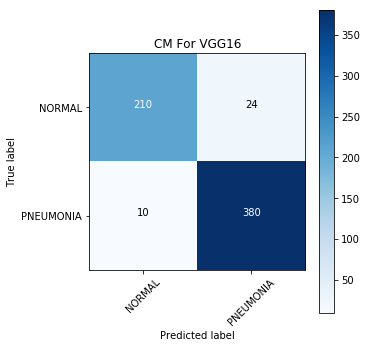

In [42]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)

cm_plt_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plt_labels, title ='CM For VGG16')

# Simple Average Ensemble Predictions

In [43]:
# Average respective values between predictions of VGG16 and VGG19

ensemble = (np.array(predictions_vgg16) + np.array(predictions_vgg19)) / 2
print (ensemble)

[[ 0.47755337  0.52840853]
 [ 0.47755337  0.52840853]
 [ 0.47755337  0.52840853]
 ..., 
 [ 0.52166581  0.47403347]
 [ 0.52166581  0.47403347]
 [ 0.52166581  0.47403347]]


In [44]:
# Select index of predictions

ensemble_categorical = np.argmax(ensemble, axis=-1)
print (ensemble_categorical)

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

In [45]:
cm_ensemble = confusion_matrix(test_labels, ensemble_categorical)

Confusion matrix, without normalization
[[201  33]
 [  9 381]]


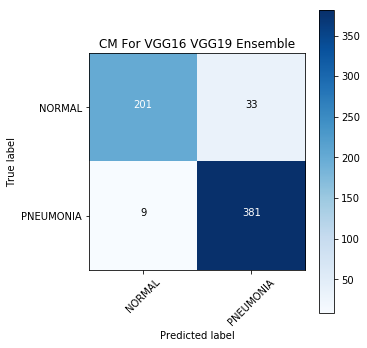

In [46]:
plot_confusion_matrix(cm_ensemble, cm_plt_labels, title ='CM For VGG16 VGG19 Ensemble')

# Individual Misclassified and Well Classified Images Results from Ensemble

In [47]:
# Misclassified results where prediction and label do not equal

misclassified_examples = np.not_equal(ensemble_categorical, test_labels).nonzero()
misclassified_paths = test_paths[np.array([misclassified_examples])]

print (misclassified_paths)

# Well classified results where prediction and label do equal

well_classified_examples = np.equal(ensemble_categorical, test_labels).nonzero()
well_classified_paths = test_paths[np.array([well_classified_examples])]

print (well_classified_paths)

[[['chest_xray/test/PNEUMONIA/person172_bacteria_828.jpeg'
   'chest_xray/test/PNEUMONIA/person117_bacteria_557.jpeg'
   'chest_xray/test/PNEUMONIA/person79_virus_148.jpeg'
   'chest_xray/test/PNEUMONIA/person153_bacteria_726.jpeg'
   'chest_xray/test/PNEUMONIA/person119_bacteria_568.jpeg'
   'chest_xray/test/PNEUMONIA/person154_bacteria_728.jpeg'
   'chest_xray/test/PNEUMONIA/person15_virus_46.jpeg'
   'chest_xray/test/PNEUMONIA/person20_virus_51.jpeg'
   'chest_xray/test/PNEUMONIA/person152_bacteria_724.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0237-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0206-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0222-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0238-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0028-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0233-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0217-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0219-0001.jpeg'
   'chest_xray/test/NORMAL/NORMAL2-IM-0246-0001.jpe